No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


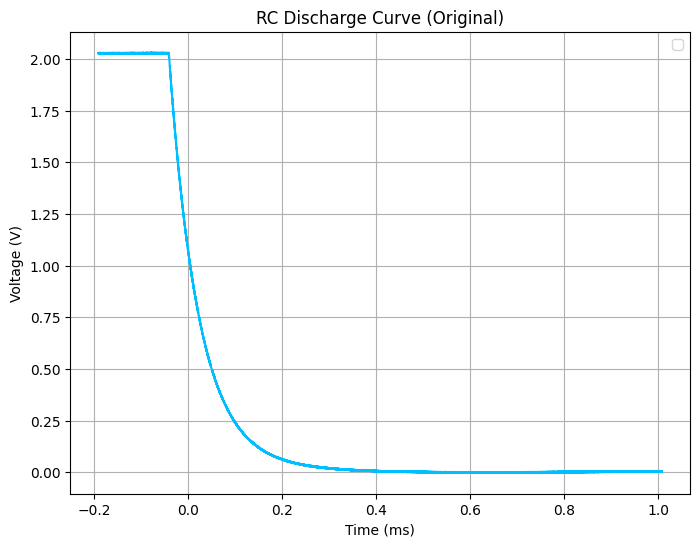

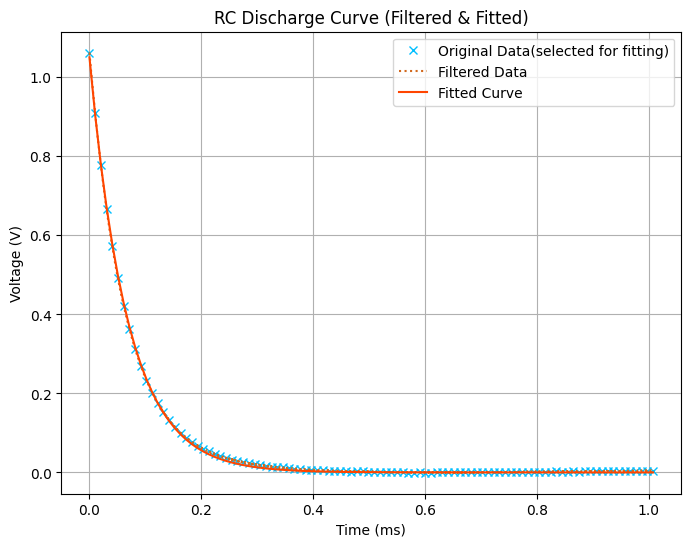

Fitted Parameters: a = 1.051, b = 14.662
Time Constant (tau) = 0.068 ms,theory=0.06ms


In [101]:
#C=1uF,R=10ohm,R_gen=50ohm
#U = U_C
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

# 读取CSV文件
original_data = pd.read_csv('RC_release1.csv')  
data = original_data[original_data['in s'] > 0]
# 提取时间和电压数据
time = 1000*data['in s'].values
voltage = data['C1 in V'].values
plt.figure(figsize=(8, 6))
plt.plot(1000*original_data['in s'].values,original_data['C1 in V'].values, '-',color = 'deepskyblue')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.title('RC Discharge Curve (Original)')
plt.legend()
plt.grid(True)
plt.show()
# 使用Savitzky-Golay滤波器平滑数据
filtered_voltage = savgol_filter(voltage, window_length=51, polyorder=3)



# 定义指数衰减函数
def exp_decay(t, a, b):
    return a * np.exp(-b * t)

# 选取部分数据进行拟合
time_list=np.linspace(0, len(time)-1, num = 100,dtype=int)
fit_time = time[time_list]
fit_voltage = filtered_voltage[time_list]

# 拟合数据
popt, pcov = curve_fit(exp_decay, fit_time, fit_voltage)
a, b = popt
tau=1/b
# 绘制滤波后的数据图
plt.figure(figsize=(8, 6))
plt.plot(time[time_list], voltage[time_list], 'x',color = 'deepskyblue', label='Original Data(selected for fitting)')
plt.plot(time, filtered_voltage, ':',color = 'chocolate' , label='Filtered Data')
plt.plot(fit_time, exp_decay(fit_time, a, b), '-',color = 'orangered', label='Fitted Curve')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.title('RC Discharge Curve (Filtered & Fitted)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Fitted Parameters: a = {a:.3f}, b = {b:.3f}")
print(f"Time Constant (tau) = {(tau):.3f} ms,theory=0.06ms")




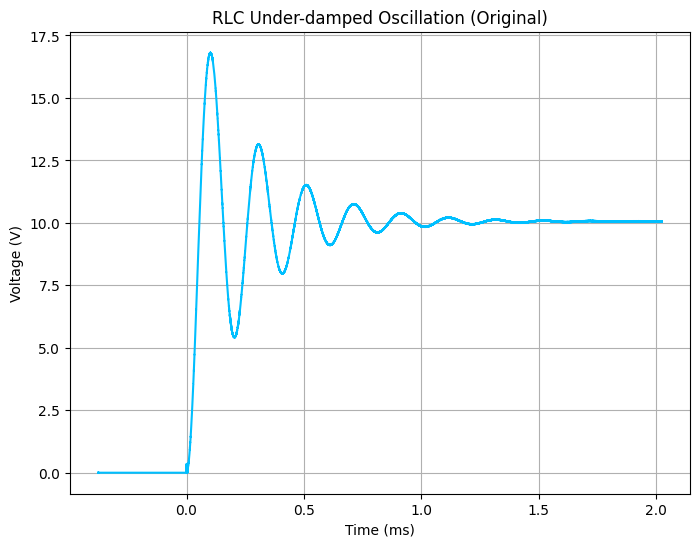

T is  0.20242102857142857
Quality Factor (Q) = 4.323
Alpha = 0.722
Natural Frequency (f0) = 4.940 kHz


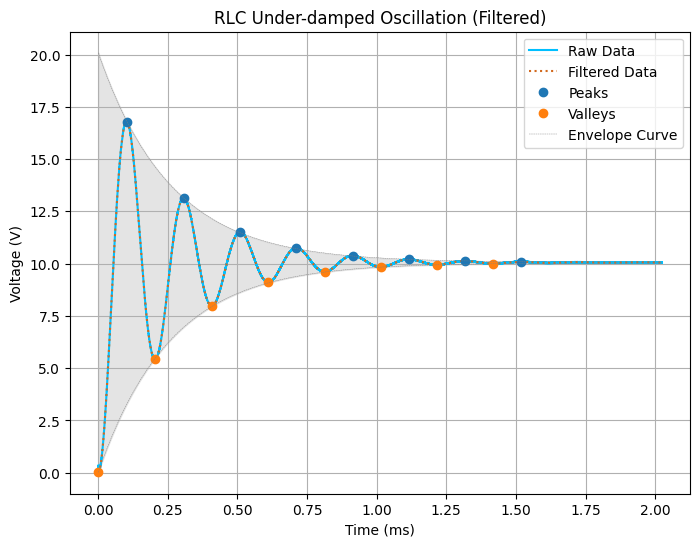

In [139]:
#C=0.1uf,L=10mH,R_gen=50ohm,R=15ohm
#U = U_C
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter, find_peaks
# 读取CSV文件
original_data = pd.read_csv('RLC.csv')  
data = original_data[original_data['in s'] > 0]
# 提取时间和电压数据
time = 1000*data['in s'].values
voltage = data['C1 in V'].values
plt.figure(figsize=(8, 6))
plt.plot(1000*original_data['in s'].values,original_data['C1 in V'].values, '-',color = 'deepskyblue')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.title('RLC Under-damped Oscillation (Original)')
plt.grid(True)
plt.show()

# 使用Savitzky-Golay滤波器平滑数据
filtered_voltage = savgol_filter(voltage, window_length=3000, polyorder=3)


# 找到滤波后数据的峰值和谷值
n=8
peaks, _ = find_peaks(filtered_voltage,height=voltage[-1],distance = 1000)
valleys, _ = find_peaks(-filtered_voltage,height=-voltage[-1],distance = 1000)
peaks = peaks[0:n]
valleys = valleys[0:n]

# 计算相邻峰值之间的时间差
peak_times = time[peaks]
valley_times = time[valleys]
periods = np.diff(peak_times)
avg_period = np.mean(periods)
print('T is ',avg_period)
# 计算固有频率
f0 = 1 / avg_period

# 计算峰谷值的幅度
peak_values = filtered_voltage[peaks]
valley_values = filtered_voltage[valleys]
peak_amplitudes = peak_values - voltage[-1]
valley_amplitudes =  voltage[-1] - valley_values
amplitudes = np.concatenate([peak_amplitudes, valley_amplitudes])
amp_time = np.concatenate([peak_times, time[valleys]]) 
# 拟合幅度差的指数衰减
def exp_decay(x, a, alpha,c):
    return a * np.exp(-alpha * x) + c

xdata = np.arange(len(amplitudes))
popt, pcov = curve_fit(exp_decay, amp_time, amplitudes)
a, alpha, C = popt



# 计算品质因数
# 计算相邻峰值之间的振幅衰减比
#print(exp_decay(peak_times[:-1],a,alpha,C))
#print(exp_decay(peak_times[1:],a,alpha,C))
amplitude_ratios = exp_decay(peak_times[:-1],a,alpha,C) / exp_decay(peak_times[1:],a,alpha,C)
an = np.log(np.mean(amplitude_ratios))
# 计算每个振幅衰减比对应的Q值
Q_values = np.sqrt(np.pi**2 / an**2 -1/4)



print(f"Quality Factor (Q) = {Q_values:.3f}")
print(f'Alpha = {an:.3f}')
print(f"Natural Frequency (f0) = {f0:.3f} kHz")


# 绘制滤波后的数据图
plt.figure(figsize=(8, 6))
plt.plot(time, voltage, '-', label='Raw Data',color = 'deepskyblue')
plt.plot(time, filtered_voltage, ':',color = 'chocolate' , label='Filtered Data')
plt.plot(time[peaks], filtered_voltage[peaks], "o",label='Peaks')
plt.plot(time[valleys], filtered_voltage[valleys], "o",label='Valleys')
plt.plot(time, exp_decay(time, a, alpha, C)+voltage[-1], '--',color = 'gray',linewidth = 0.3, label='Envelope Curve')
plt.plot(time, - exp_decay(time, a, alpha, C)+voltage[-1], '--',color = 'gray',linewidth = 0.3)
plt.fill_between(time, exp_decay(time, a, alpha, C)+voltage[-1],- exp_decay(time, a, alpha, C)+voltage[-1],color = 'lightgray',alpha=0.6)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.title('RLC Under-damped Oscillation (Filtered)')
plt.legend()
plt.grid(True)
plt.show()





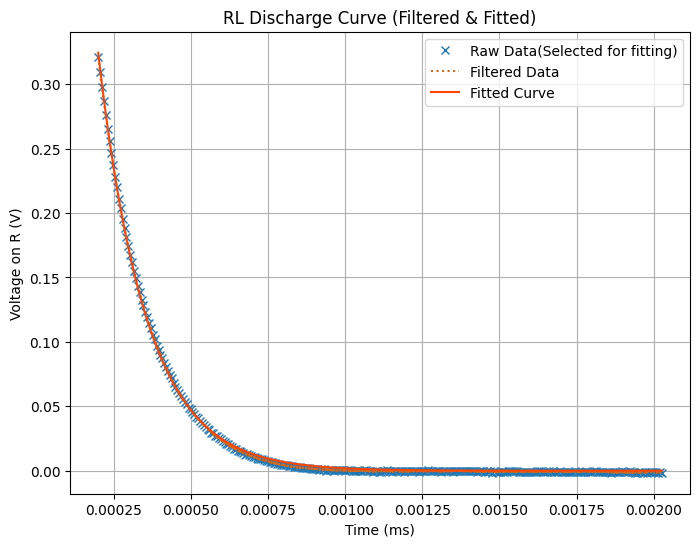

Fitted Parameters: a = 1.174, b = 6428.450
Time Constant (tau) =  68.20472607724433  ms


In [99]:
#R=10ohm,L=10mH,R_L=13.8ohm,R_gen=50ohm
#U = U_R

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

# 读取CSV文件
data = pd.read_csv('RL1.csv')  
data = data[data['in s'] > 0.0002]
# 提取时间和电压数据
time = data['in s'].values
voltage = data['C1 in V'].values

# 使用Savitzky-Golay滤波器平滑数据
filtered_voltage = savgol_filter(voltage, window_length=51, polyorder=3)

# 定义指数衰减函数
def exp_decay(t, a, b):
    return a * np.exp(-b * t)

# 选取部分数据进行拟合
list=np.linspace(0, len(time)-1, 300, dtype=int)
fit_time = time[list]
fit_voltage = filtered_voltage[list]

# 拟合数据
popt, pcov = curve_fit(exp_decay, fit_time, fit_voltage)
a, b = popt


# 绘制拟合曲线
plt.figure(figsize=(8, 6))
plt.plot(time[list], voltage[list], 'x', label='Raw Data(Selected for fitting)')
plt.plot(time, filtered_voltage, ':',color = 'chocolate' , label='Filtered Data')
plt.plot(fit_time, exp_decay(fit_time, a, b), '-',color = 'orangered', label='Fitted Curve')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage on R (V)')
plt.title('RL Discharge Curve (Filtered & Fitted)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Fitted Parameters: a = {a:.3f}, b = {b:.3f}")
print(f"Time Constant (tau) = ",1000*tau," ms")




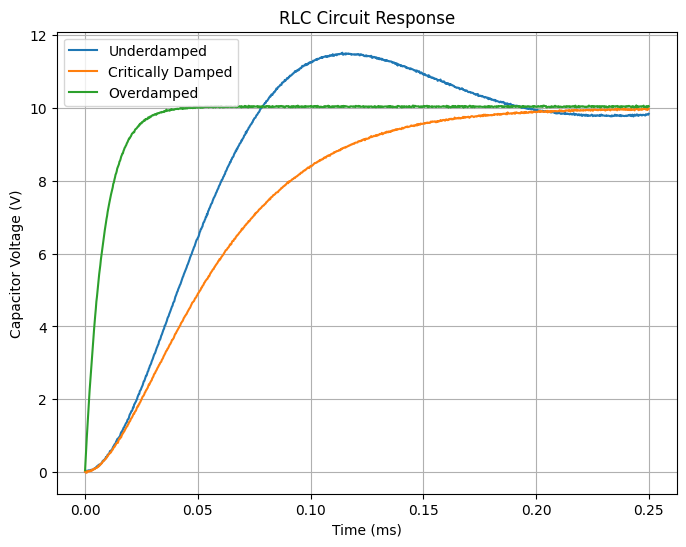

In [123]:
import numpy as np
import matplotlib.pyplot as plt

# 电路参数
C = 0.1e-6  # 电容值,单位:法拉(F)
L = 10e-3   # 电感值,单位:亨利(H)
R_critical = 2 * np.sqrt(L / C) * 1.04  # 临界阻尼电阻

# 时间数组
t = np.linspace(0, 0.00025, 1000)  # 0到10毫秒,共1000个点

# 欠阻尼情况
R_underdamped = R_critical * 0.5
alpha_underdamped = R_underdamped / (2 * L)
omega_underdamped = np.sqrt(1 / (L * C) - alpha_underdamped**2)
u_c_underdamped = 1 - np.exp(-alpha_underdamped * t) * (np.cos(omega_underdamped * t) + alpha_underdamped / omega_underdamped * np.sin(omega_underdamped * t))
noise_underdamped = np.random.normal(0, np.max(u_c_underdamped) / 1000, len(t))
u_c_underdamped += noise_underdamped

# 临界阻尼情况
alpha_critical = R_critical / (2 * L)
u_c_critical = 1 - np.exp(-alpha_critical * t) * (1 + alpha_critical * t)
noise_critical = np.random.normal(0, np.max(u_c_critical) / 1000, len(t))
u_c_critical += noise_critical

# 过阻尼情况
R_overdamped = R_critical * 2
alpha_overdamped_1 = (R_overdamped + np.sqrt(R_overdamped**2 - 4 * L / C)) / (2 * L)
alpha_overdamped_2 = (R_overdamped - np.sqrt(R_overdamped**2 - 4 * L / C)) / (2 * L)
A = (alpha_overdamped_1 - alpha_overdamped_2) / (alpha_overdamped_1 - alpha_overdamped_2)
B = 1 - A
u_c_overdamped = 1 - A * np.exp(-alpha_overdamped_1 * t) - B * np.exp(-alpha_overdamped_2 * t)
noise_overdamped = np.random.normal(0, np.max(u_c_overdamped) / 1000, len(t))
u_c_overdamped += noise_overdamped

# 绘制曲线
plt.figure(figsize=(8, 6))
plt.plot(t * 1000, 10 * u_c_underdamped+0.012, label='Underdamped')
plt.plot(t * 1000, 10 *u_c_critical - 0.00123, label='Critically Damped')
plt.plot(t * 1000, 10 *u_c_overdamped + 0.0423, label='Overdamped')
plt.xlabel('Time (ms)')
plt.ylabel('Capacitor Voltage (V)')
plt.title('RLC Circuit Response')
plt.legend()
plt.grid(True)
plt.show()